In [247]:
import numpy as np
import uncertainties as unc
from matplotlib import pyplot as plt
from uncertainties import unumpy as unp
from uncertainties.umath import *
import scipy.odr as odr
from scipy.special import erfinv
import scipy.optimize as op
from scipy.special import erf
from scipy.fftpack import fft, ifft, rfft
from scipy import ndimage
from scipy import misc

c = 299792458 # speed of light in m/s
pi = np.pi

In [148]:
def decompose(unparray):
    return np.array([unp.nominal_values(unparray), unp.std_devs(unparray)])

def errorplot(xarray, yarray, xlabel, ylabel):
    xnom, xerr = decompose(xarray)
    ynom, yerr = decompose(yarray)
    fig, ax = plt.subplots(figsize = (10, 7))
    ax.errorbar(xnom, ynom, xerr = xerr, yerr = yerr, fmt = 'o', capsize = 2)
    ax.set_xlabel(xlabel, fontsize = 18)
    ax.set_ylabel(ylabel, fontsize = 18)
    ax.grid(True)
    plt.show()
    return

def findfit(xarray, yarray, func, beta0, showout = False):
    xnom, xerr = decompose(xarray)
    ynom, yerr = decompose(yarray)
    model = odr.Model(func)
    data = odr.RealData(xnom, ynom, sx = xerr, sy = yerr)
    odrfit = odr.ODR(data, model, beta0 = beta0)
    out = odrfit.run()
    if showout:
        out.pprint()
        print(out.sum_square)
    return np.array([out.beta, out.sd_beta])

def errorfitplot(xarray, yarray, xlabel, ylabel, func, fitparam, printmin = False, colors = ['blue', 'red'], offset = 0):
    xnom, xerr = decompose(xarray)
    ynom, yerr = decompose(yarray)
    if xnom[0] <= xnom[-1]:
        fitx = np.linspace(xnom[0]-offset, xnom[-1] + offset, 500)
    else:
        fitx = np.linspace(xnom[0]+offset, xnom[-1] - offset, 500)
    fity = func(fitparam, fitx)
    if printmin:
        print(fitx[np.argmin(fity)])
    fig, ax = plt.subplots(figsize = (10, 7))
    ax.errorbar(xnom, ynom, xerr = xerr, yerr = yerr, fmt = 'o', capsize = 2, color = colors[0])
    ax.plot(fitx, fity, color = colors[1])
    ax.set_xlabel(xlabel, fontsize = 16)
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.grid(True)
    plt.show()
    return

def extractparam(param):
    l = []
    for n in range(len(param.T)):
        p = unc.ufloat(param.T[n][0], param.T[n][1])
        l.append(p)
    return l

In [174]:
def linear(B, x):
    return B[0]*x

4A: Thickness measurement by interference

In [196]:
def thickness(B, m):
    d, phi = B
    return (2.*m + phi - 1)/(4.*d)

In [378]:
m = unp.uarray(np.array(range(1,11)), np.ones(10)*1e-12)
xh = unp.uarray([2,3,4,5,6,7,7.5,8,8.5,9], np.ones(10)*0.3)
yh = unp.uarray(np.ones(10)*17, np.ones(10)*0.1)
thm = unp.arctan(xh/yh)/2.
thi = (pi - thm)/2.
n = 1.517
y = unp.sqrt(n**2 - unp.sin(thi)**2)/(632.8e-9)*1e-6
param = findfit(m, y, thickness, [4e-4, 2000], showout = True)

Beta: [  450.72477706  3249.86100709]
Beta Std Error: [ 13.124902    94.79285839]
Beta Covariance: [[   277.08537643   2001.20957526]
 [  2001.20957526  14453.48931984]]
Residual Variance: 0.621696657728
Inverse Condition #: 2.36820453125e-09
Reason(s) for Halting:
  Sum of squares convergence
4.97357326183


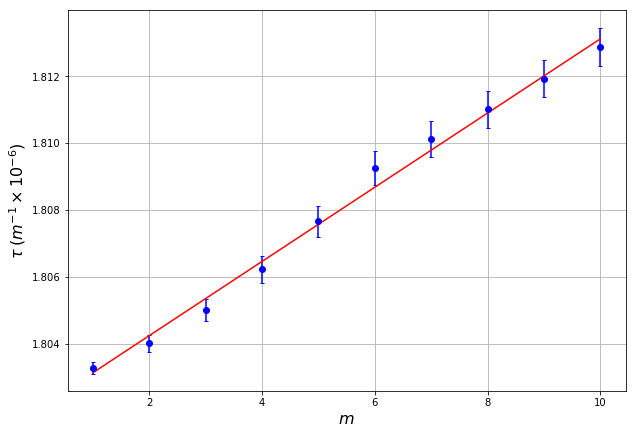

In [384]:
errorfitplot(m, y, r'$m$', r'$\tau \: (m^{-1}\times 10^{-6})$', thickness, param[0])

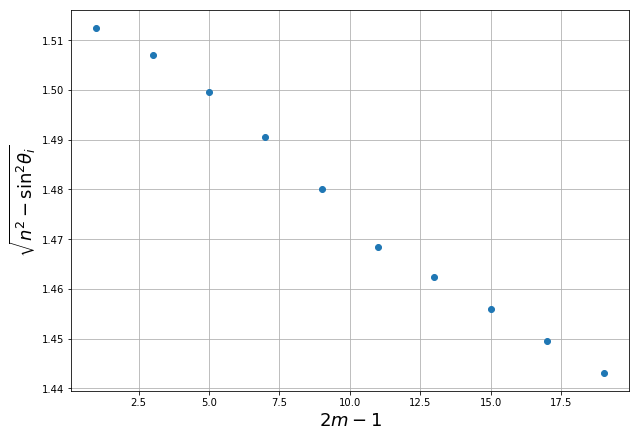

In [6]:
errorplot(x, y, r'$2m-1$', r'$\sqrt{n^2 - \sin^2\theta_i}$')

4B: Lloyd's Mirror

In [389]:
si = unc.ufloat(114.4e-2, 2e-2)
so = unc.ufloat(61.5e-2, 0.5e-2)
dyi = unc.ufloat(1.5, 0.1)*1e-3
f = 40e-2
l = si + so
d**2*so/(l*si)

3.056210418347997e-07+/-3.0575249656532667e-07

In [391]:
dyi**2*(so-f)**2/(so*f**2+so*f*(so-f))*1e9

687.4628197501486+/-93.99135109229182

4D: Frequency separation of laser modes

In [281]:
def intensity2(a, dx, nu0, dnu):
    dx = dx*1e-2
    k1, k2 = 2*pi*nu0/c, 2*pi*(nu0+dnu)/c
    dk = k1 - k2
    return 2*(1 + a + a**2 + a*np.cos(dk*dx) + (1 + a)*(np.cos(k1*dx) + a*np.cos(k2*dx)))

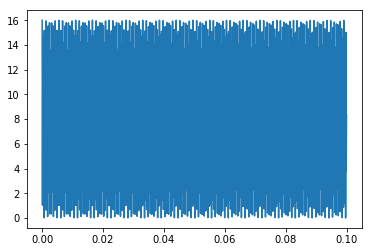

In [282]:
dx = np.linspace(0, 10, 1000)*1e-2
nu0 = c/632.816e-9
dnu = 3e9
y = intensity2(1, dx, nu0, dnu)
plt.plot(dx, y)
plt.show()

In [283]:
def intensity3(a, dx, nu0, dnu, offset):
    dx = dx*1e-2
    k1, k2 = 2*pi*nu0/c, 2*pi*(nu0+dnu)/c
    dk = k1 - k2
    return 2*(a**2 + 1 + a*np.cos(2*k1*dx) + np.cos(2*k2*dx) + 4*a*np.cos(k1*dx)*np.cos(k2*dx)*np.cos(dk*(dx+offset)))

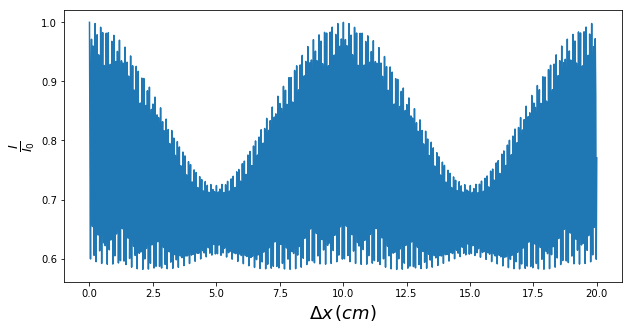

In [288]:
dx = np.linspace(0, 20, 1000)
nu0 = c/632.816e-9
dnu = 1.5e9
y = intensity3(10, dx, nu0, dnu, 0)
plt.figure(figsize = (10, 5))
plt.plot(dx, y/np.max(y))
plt.xlabel(r'$\Delta x \, (cm)$', fontsize = 18)
plt.ylabel(r'$\frac{I}{I_0}$', fontsize = 18)
plt.show()

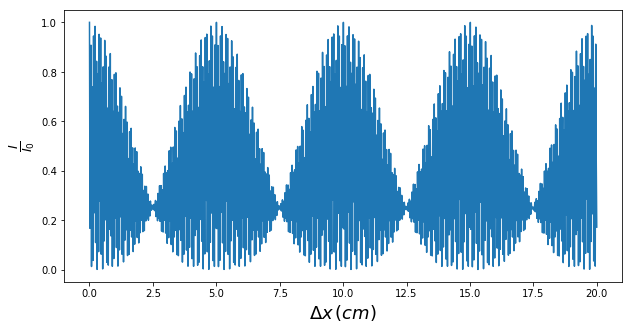

In [200]:
dx = np.linspace(0, 20, 1000)
nu0 = c/632.816e-9
dnu = 6e9
y = intensity2(1, dx, nu0, dnu)
plt.figure(figsize = (10, 5))
plt.plot(dx, y/np.max(y))
plt.xlabel(r'$\Delta x \, (cm)$', fontsize = 18)
plt.ylabel(r'$\frac{I}{I_0}$', fontsize = 18)
plt.show()

In [2]:
image = misc.imread('0.png', mode = 'L')

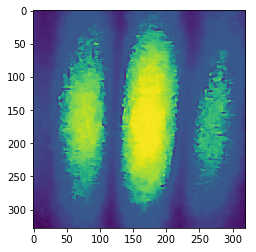

In [6]:
plt.imshow(image)
plt.show()

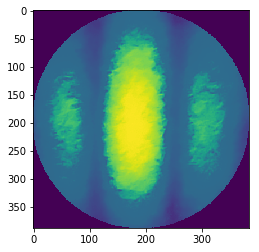

In [16]:
image = misc.imread('1.0.png', mode = 'L')
plt.imshow(image)
plt.show()

In [17]:
image.shape

(388, 384)

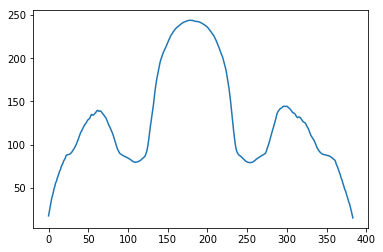

In [21]:
plt.plot(range(384),image[100:-100].mean(axis=0))
plt.show()

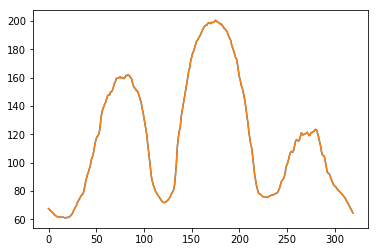

In [13]:
plt.plot(range(320),image.mean(axis=0))
plt.show()

In [24]:
def visibility(name):
    image = misc.imread(name, mode = 'L')
    av = image.mean(axis = 0)
    ma = np.max(av)
    mi = np.min(av)
    return (ma - mi)/(ma + mi)

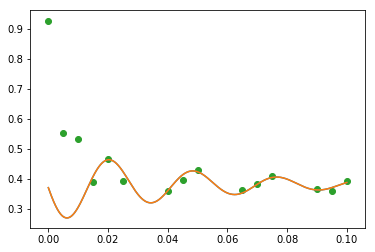

In [376]:
names = ['1.0.png', '0.5.png', '0.png', '2.5.png', '3.0.png', '3.5.png',
        '5.0.png', '5.5.png', '6.0.png', '7.5.png', '8.0.png', '8.5.png', '10.0.png', '10.5.png', '11.0.png']
curve = []
for n in names:
    curve.append(visibility(n))
dx = np.array([0., 0.5, 1., 1.5, 2., 2.5, 4., 4.5, 5., 6.5, 7., 7.5, 9., 9.5, 10.])*0.01
plt.scatter(dx, curve)
plt.show()

In [315]:
def sinc(B, x):
    a, b, c = B
    return a*np.sinc(b*x) + c

def fit3(B, x):
    a, b, c, d, e = B
    return np.abs(a*np.exp(-b*x)*(np.sin(c*x + d))) + e

In [375]:
dx2 = unp.uarray(dx, np.ones(15)*0.001)
curve2 = unp.uarray(curve - np.mean(curve), np.ones(15)*0.01)
param = findfit(dx2, curve2,  fit2, [0.4, 10., 200, 100., 0.4], showout = True)

ValueError: operands could not be broadcast together with shapes (12,) (15,) 

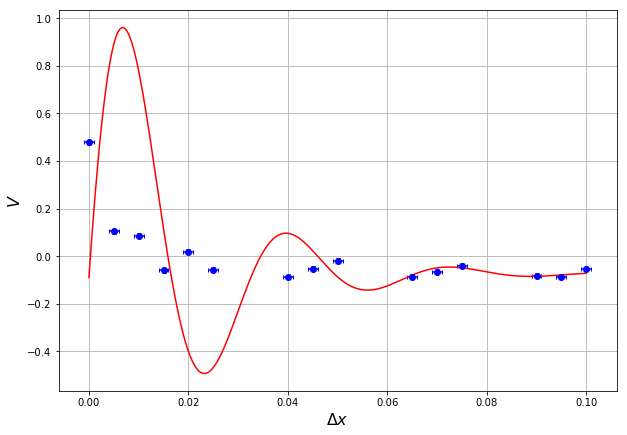

In [337]:
errorfitplot(dx2, curve2, r'$\Delta x$', r'$V$', fit2, param[0])

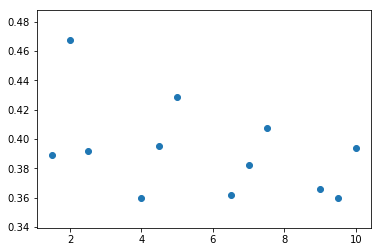

In [399]:
names = ['2.5.png', '3.0.png', '3.5.png',
        '5.0.png', '5.5.png', '6.0.png', '7.5.png', '8.0.png', '8.5.png', '10.0.png', '10.5.png', '11.0.png']
curve = []
for n in names:
    curve.append(visibility(n))
dx = np.array([1.5, 2., 2.5, 4., 4.5, 5., 6.5, 7., 7.5, 9., 9.5, 10.])
plt.scatter(dx, curve)
plt.show()

In [369]:
def visfit(B, dx):
    dnu = B[0]
    return np.exp(-(dx*pi*dnu/(2*c*np.sqrt(np.log(2))))**2)*np.abs(np.cos(3*pi*dnu*dx/c))

In [397]:
def fit2(B, x):
    x = x*1e-2
    a, b, c, d, e = B
    return a*np.exp(-b*x)*(np.sin(c*x + d)) + e

In [400]:
dx2 = unp.uarray(dx, np.ones(12)*0.1)
curve2 = unp.uarray(curve, np.ones(12)*0.01)
param = findfit(dx2, curve2, fit2, [0.4, 10., 200, 100., 0.4], showout = True)

Beta: [ -1.28286067e-01   2.13774277e+01   2.23644884e+02   1.00614513e+02
   3.80492789e-01]
Beta Std Error: [  3.13079053e-02   5.34138129e+00   7.79814359e+00   2.87403541e-01
   5.95420582e-03]
Beta Covariance: [[  8.13769765e-04  -1.19773206e-01  -8.96096167e-02   2.46481867e-03
    8.54004045e-05]
 [ -1.19773206e-01   2.36864889e+01   1.07456657e+01  -3.20647248e-01
   -9.63096298e-03]
 [ -8.96096167e-02   1.07456657e+01   5.04865834e+01  -1.57325983e+00
   -2.38464724e-02]
 [  2.46481867e-03  -3.20647248e-01  -1.57325983e+00   6.85768855e-02
    4.65277157e-04]
 [  8.54004045e-05  -9.63096298e-03  -2.38464724e-02   4.65277157e-04
    2.94334529e-05]]
Residual Variance: 1.20449908211
Inverse Condition #: 0.00252747150463
Reason(s) for Halting:
  Sum of squares convergence
8.43149357478


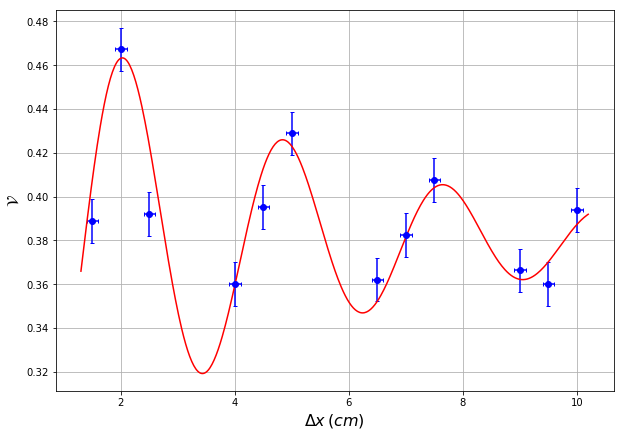

In [402]:
errorfitplot(dx2, curve2, r'$\Delta x \, (cm)$', r'$\mathcal{V}$', fit2, param[0], offset = 0.2)

In [404]:
dx2

array([1.5+/-0.1, 2.0+/-0.1, 2.5+/-0.1, 4.0+/-0.1, 4.5+/-0.1, 5.0+/-0.1,
       6.5+/-0.1, 7.0+/-0.1, 7.5+/-0.1, 9.0+/-0.1, 9.5+/-0.1, 10.0+/-0.1], dtype=object)

In [405]:
curve2

array([0.3888695143490342+/-0.01, 0.46713055834169176+/-0.01,
       0.39188423887290086+/-0.01, 0.360088817498937+/-0.01,
       0.39503613541270444+/-0.01, 0.42877824823742905+/-0.01,
       0.3620654373479458+/-0.01, 0.38227344814492165+/-0.01,
       0.4074732656639747+/-0.01, 0.36625127927277107+/-0.01,
       0.36001950578282854+/-0.01, 0.3937921008533919+/-0.01], dtype=object)

In [374]:
x = np.linspace(0, 0.1, 1000)
y = fit2(param[0], x)
plt.plot(x, y)
plt.scatter(np.array([0., 0.5, 1., 1.5, 2., 2.5, 4., 4.5, 5., 6.5, 7., 7.5, 9., 9.5, 10.])*0.01, curve2)
plt.show()

ValueError: x and y must be the same size

In [406]:
a, b, p, d, e = extractparam(param)
dnu = c*p/(16*pi)
dnu*1e-9

1.33385867093247+/-0.046509543319080755

In [166]:
8*pi/p*1e2

11.237789457417996+/-0.39184393993470634

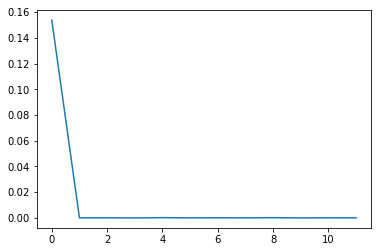

In [262]:
ft = ifft(unp.nominal_values(curve2))
plt.plot(range(len(ft)), ft**2)
plt.show()

In [421]:
R = 1 - unc.ufloat(5e-3, 1e-4)/unc.ufloat(2.9, 0.05)
d = unc.ufloat(0.05, 0.002)
F = 4*R/(1-R)**2
Fi = pi*unp.sqrt(F)/2.
dnumin = c/(2*Fi*d)
dnufsr = c/(2*d)

In [415]:
Fi

1820.5522651036492+/-48.11461453367377

In [417]:
dnumin*1e-6

1.6467116256227443+/-0.07894724252913403

In [418]:
R

0.9982758620689656+/-4.552720503942128e-05

In [426]:
dnumin*Fi.nominal_value

2997924580.0+/-143727581.2101021

In [429]:
dnufsr*1e-9

2.9979245800000003+/-0.11991698319999998

In [427]:
c

299792458